In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. 티커 설정
# ---------------------------------------------------------
luxury_tickers = ['LVMUY', 'HESAY', 'CFRUY']
essential_tickers = ['WMT', 'COST', 'MCD']
market_tickers = ['^VIX']

all_tickers = luxury_tickers + essential_tickers + market_tickers

# ---------------------------------------------------------
# 2. 데이터 다운로드
# ---------------------------------------------------------
print("데이터 다운로드 시작...", end="")
# group_by='ticker' 옵션을 끄고 기본값(column-wise)으로 받습니다.
df = yf.download(all_tickers, start='2000-01-01', interval='1mo', progress=False)
print(" 완료!")

# ---------------------------------------------------------
# 3. 데이터 구조 확인 (이 결과를 보고 다음 코드를 실행합니다)
# ---------------------------------------------------------
print("\n[데이터 컬럼 구조 확인]")
print(df.columns)

print("\n[데이터 상위 5개 행]")
print(df.head())
df.to_csv('data/raw_stock_data.csv')

데이터 다운로드 시작...

C:\Users\zinhyeok\AppData\Local\Temp\ipykernel_11540\1001682263.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(all_tickers, start='2000-01-01', interval='1mo', progress=False)


 완료!

[데이터 컬럼 구조 확인]
MultiIndex([( 'Close', 'CFRUY'),
            ( 'Close',  'COST'),
            ( 'Close', 'HESAY'),
            ( 'Close', 'LVMUY'),
            ( 'Close',   'MCD'),
            ( 'Close',   'WMT'),
            ( 'Close',  '^VIX'),
            (  'High', 'CFRUY'),
            (  'High',  'COST'),
            (  'High', 'HESAY'),
            (  'High', 'LVMUY'),
            (  'High',   'MCD'),
            (  'High',   'WMT'),
            (  'High',  '^VIX'),
            (   'Low', 'CFRUY'),
            (   'Low',  'COST'),
            (   'Low', 'HESAY'),
            (   'Low', 'LVMUY'),
            (   'Low',   'MCD'),
            (   'Low',   'WMT'),
            (   'Low',  '^VIX'),
            (  'Open', 'CFRUY'),
            (  'Open',  'COST'),
            (  'Open', 'HESAY'),
            (  'Open', 'LVMUY'),
            (  'Open',   'MCD'),
            (  'Open',   'WMT'),
            (  'Open',  '^VIX'),
            ('Volume', 'CFRUY'),
            ('Volume',


[최종 데이터 요약]
Ticker  Luxury_Index  Essential_Index      Spread         VIX
count     239.000000       239.000000  239.000000  239.000000
mean        0.011631         0.011736    0.059996   19.581004
std         0.100708         0.038686    0.071437    8.151226
min        -0.974229        -0.130766    0.000197    9.510000
25%        -0.028962        -0.013075    0.019573   13.860000
50%         0.018434         0.014179    0.047939   17.150000
75%         0.063241         0.032642    0.083168   23.150000
max         0.241297         0.106637    0.886332   59.889999


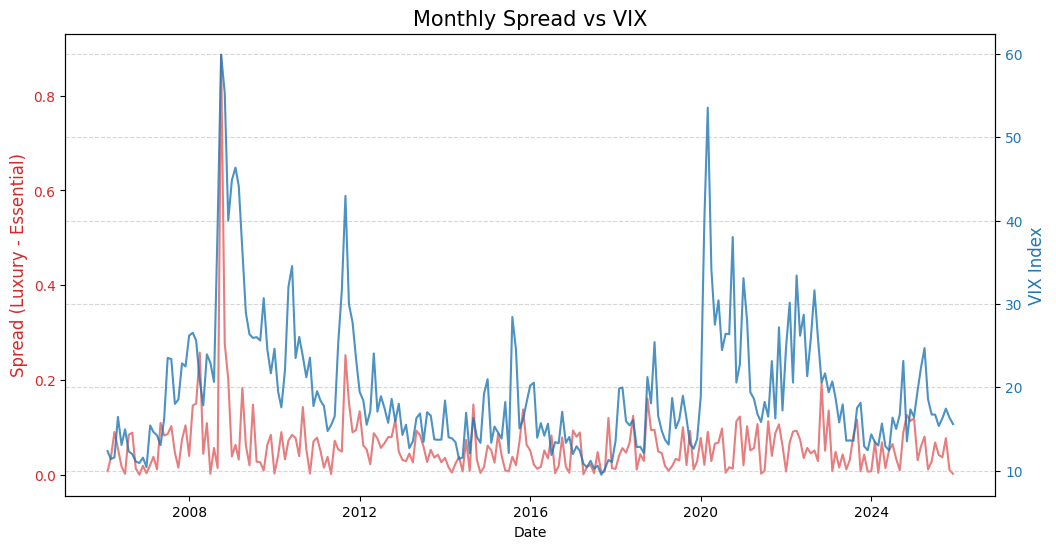

Correlation: 0.4588


In [5]:
# ---------------------------------------------------------
# 4. 데이터 전처리 (MultiIndex 에러 수정 버전)
# ---------------------------------------------------------

# 4-1. 'Adj Close' 컬럼만 추출 및 구조 평탄화
# 만약 'Adj Close'가 컬럼에 있다면 추출
if 'Adj Close' in df.columns.get_level_values(0):
    df_price = df['Adj Close'].copy()
else:
    # yfinance 버전에 따라 'Adj Close'가 없을 경우 'Close' 사용
    print("Warning: 'Adj Close' not found. Using 'Close' instead.")
    df_price = df['Close'].copy()

# 컬럼이 여전히 MultiIndex일 경우를 대비해 컬럼명을 강제로 Ticker로 통일
# 예: MultiIndex가 남아있다면 제거하고 Ticker 이름만 남김
if isinstance(df_price.columns, pd.MultiIndex):
    df_price.columns = df_price.columns.get_level_values(-1) # 마지막 레벨(Ticker)만 가져옴

# 4-2. 로그 수익률 계산
# 이제 df_price는 Ticker만 컬럼으로 가진 깔끔한 DataFrame이므로 에러가 나지 않습니다.
stock_tickers = luxury_tickers + essential_tickers

# 데이터가 비어있는지 체크
missing_tickers = [t for t in stock_tickers if t not in df_price.columns]
if missing_tickers:
    print(f"주의: 다음 티커의 데이터가 누락되었습니다 -> {missing_tickers}")
    # 누락된 티커 제외하고 진행
    stock_tickers = [t for t in stock_tickers if t in df_price.columns]

# 수익률 계산
df_returns = np.log(df_price[stock_tickers] / df_price[stock_tickers].shift(1))

# 4-3. 동일 가중 포트폴리오 및 Spread 생성
# 실제 데이터가 있는 컬럼만 골라서 평균 계산
valid_luxury = [t for t in luxury_tickers if t in df_returns.columns]
valid_essential = [t for t in essential_tickers if t in df_returns.columns]

df_returns['Luxury_Index'] = df_returns[valid_luxury].mean(axis=1)
df_returns['Essential_Index'] = df_returns[valid_essential].mean(axis=1)

# Spread 계산 (절대값)
df_returns['Spread'] = (df_returns['Luxury_Index'] - df_returns['Essential_Index']).abs()

# 4-4. VIX 데이터 병합
# VIX도 df_price에 들어있으므로 가져옴 ('^VIX' Ticker 사용)
# VIX는 수익률이 아니라 '지수 값' 자체를 사용
if '^VIX' in df_price.columns:
    df_returns['VIX'] = df_price['^VIX']
else:
    print("Error: VIX data not found!")

# 4-5. 최종 데이터셋 정리
df_final = df_returns[['Luxury_Index', 'Essential_Index', 'Spread', 'VIX']].dropna()

# ---------------------------------------------------------
# 5. 결과 시각화
# ---------------------------------------------------------
print(f"\n[최종 데이터 요약]")
print(df_final.describe())

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Spread (Luxury - Essential)', color=color, fontsize=12)
ax1.plot(df_final.index, df_final['Spread'], color=color, alpha=0.6, label='Spread')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('VIX Index', color=color, fontsize=12)
ax2.plot(df_final.index, df_final['VIX'], color=color, alpha=0.8, label='VIX')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Spread vs VIX', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 상관계수 출력
corr = df_final['Spread'].corr(df_final['VIX'])
print(f"Correlation: {corr:.4f}")

In [7]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# ---------------------------------------------------------
# Step 3: 시계열 안정성 검정 (ADF Test)
# ---------------------------------------------------------

def perform_adf_test(series, name):
    """
    ADF Test를 수행하고 결과를 보기 좋게 출력하는 함수
    """
    print(f"\n[{name} ADF Test 결과]")
    result = adfuller(series.dropna())
    
    adf_stat = result[0]
    p_value = result[1]
    
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value:       {p_value:.4f}")
    
    # 해석
    if p_value < 0.05:
        print(">> 결론: 귀무가설 기각 (데이터가 안정적임, 그대로 사용 가능)")
    else:
        print(">> 결론: 귀무가설 채택 (데이터가 불안정함, 차분 필요)")

# 1. Spread 변수 검정
perform_adf_test(df_final['Spread'], 'Spread (Luxury - Essential)')

# 2. VIX 변수 검정
perform_adf_test(df_final['VIX'], 'VIX Index')


[Spread (Luxury - Essential) ADF Test 결과]
ADF Statistic: -4.7280
p-value:       0.0001
>> 결론: 귀무가설 기각 (데이터가 안정적임, 그대로 사용 가능)

[VIX Index ADF Test 결과]
ADF Statistic: -5.3270
p-value:       0.0000
>> 결론: 귀무가설 기각 (데이터가 안정적임, 그대로 사용 가능)


In [8]:
import statsmodels.api as sm

# ---------------------------------------------------------
# Step 4: 예측 회귀 분석 (Predictive Regression)
# ---------------------------------------------------------

# 1. 시차 변수 생성 (Lag Generation)
# Spread 데이터를 한 칸 밑으로 내립니다 (t-1 데이터를 t 시점에 매칭)
df_reg = df_final.copy()
df_reg['Spread_Lag1'] = df_reg['Spread'].shift(1)

# 시차 생성으로 생긴 첫 번째 행(NaN) 제거
df_reg.dropna(inplace=True)

# 2. 회귀분석 설정 (OLS)
# 독립변수(X): 상수항(Constant) + Spread_Lag1
X = df_reg['Spread_Lag1']
X = sm.add_constant(X)  # 상수항(Intercept) 추가 필수

# 종속변수(Y): VIX
Y = df_reg['VIX']

# 3. 모델 적합 (Fitting with HAC)
# cov_type='HAC': Newey-West 표준오차 사용
# maxlags=12: 월별 데이터이므로 1년(12개월) 정도의 자기상관을 고려 (보통 T^(1/4) 혹은 12 사용)
model = sm.OLS(Y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

# 4. 결과 출력
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     88.87
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           4.11e-18
Time:                        17:40:43   Log-Likelihood:                -820.38
No. Observations:                 238   AIC:                             1645.
Df Residuals:                     236   BIC:                             1652.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          17.1531      1.211     14.163      

In [17]:
import pandas as pd
import statsmodels.api as sm
import os

# ---------------------------------------------------------
# Step 4-2: 로컬 CSV 파일을 이용한 다변량 회귀분석
# ---------------------------------------------------------

def load_local_fred_data(filename):
    """
    같은 폴더에 있는 CSV 파일을 읽어옵니다.
    """
    if not os.path.exists(filename):
        print(f"[오류] '{filename}' 파일을 찾을 수 없습니다.")
        print("다운로드한 CSV 파일이 코드와 같은 폴더에 있는지 확인해주세요.")
        return None
        
    print(f"Reading {filename}...", end="")
    try:
        # '.'은 결측치로 처리 (FRED 데이터 특성)
        df = pd.read_csv(filename, index_col='observation_date', parse_dates=True, na_values='.')
        print(" 완료")
        return df
    except Exception as e:
        print(f" 실패 ({e})")
        return None

# 1. 로컬 파일 읽기
df_term = load_local_fred_data('data/T10Y2Y.csv')
df_credit = load_local_fred_data('data/BAA10Y.csv')

df_term.head()

Reading data/T10Y2Y.csv... 완료
Reading data/BAA10Y.csv... 완료


,T10Y2Y
observation_date,
2000-01-03,0.20
2000-01-04,0.19
2000-01-05,0.24
2000-01-06,0.22
2000-01-07,0.21


In [18]:
# 2. 데이터가 정상적으로 로드되었는지 확인
if df_term is not None and df_credit is not None:
    # 3. 데이터 가공 (일별 데이터를 월별 평균으로 변환)
    # 데이터 타입이 문자로 인식될 수 있으므로 숫자형으로 강제 변환
    df_term = df_term.apply(pd.to_numeric, errors='coerce')
    df_credit = df_credit.apply(pd.to_numeric, errors='coerce')
    
    # 월별 평균(Month End Mean)으로 리샘플링
    df_term_m = df_term.resample('ME').mean()
    df_credit_m = df_credit.resample('ME').mean()
    
    # 4. 병합을 위한 DataFrame 생성
    df_macro = pd.DataFrame()
    # 컬럼명이 파일마다 다를 수 있으므로 첫 번째 컬럼을 가져옴
    df_macro['Term_Spread'] = df_term_m.iloc[:, 0]
    df_macro['Credit_Spread'] = df_credit_m.iloc[:, 0]
    
    # 5. 기존 df_final(Spread, VIX)과 병합
    # 인덱스 타입을 datetime으로 확실히 변환
    df_final.index = pd.to_datetime(df_final.index)
    
    # 인덱스 주기를 월말(Month End)로 통일
    df_final_resampled = df_final.resample('ME').last() 
    
    # Inner Join으로 교집합 기간만 남김
    df_multi = pd.merge(df_final_resampled, df_macro, left_index=True, right_index=True, how='inner')
    
    print(f"\n[데이터 병합 완료] 분석 기간: {df_multi.index[0].date()} ~ {df_multi.index[-1].date()}")

    # 6. 시차 변수(Lag) 생성 (t-1 시점 데이터 생성)
    df_reg_multi = df_multi.copy()

    # 독립변수 Lag 생성
    df_reg_multi['Spread_Lag1'] = df_reg_multi['Spread'].shift(1)
    df_reg_multi['Term_Spread_Lag1'] = df_reg_multi['Term_Spread'].shift(1)
    df_reg_multi['Credit_Spread_Lag1'] = df_reg_multi['Credit_Spread'].shift(1)
    
    # [중요] VIX의 자기상관(Persistence) 통제
    df_reg_multi['VIX_Lag1'] = df_reg_multi['VIX'].shift(1)

    # 결측치 제거
    df_reg_multi.dropna(inplace=True)

    # 7. 다변량 회귀분석 수행 (Multivariate OLS)
    # Model: VIX_t = a + b1*Spread_{t-1} + b2*Term_{t-1} + b3*Credit_{t-1} + b4*VIX_{t-1}

    # X (독립변수)
    features = ['Spread_Lag1', 'Term_Spread_Lag1', 'Credit_Spread_Lag1', 'VIX_Lag1']
    X_multi = df_reg_multi[features]
    X_multi = sm.add_constant(X_multi)

    # Y (종속변수)
    Y_multi = df_reg_multi['VIX']

    # 모델 적합 (HAC Standard Errors)
    model_multi = sm.OLS(Y_multi, X_multi)
    results_multi = model_multi.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

    print(results_multi.summary())

else:
    print("\n[중단] CSV 파일을 불러오지 못했습니다. 파일명과 위치를 확인해주세요.")


[데이터 병합 완료] 분석 기간: 2006-02-28 ~ 2025-12-31
                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     108.9
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.50e-52
Time:                        17:58:47   Log-Likelihood:                -720.84
No. Observations:                 238   AIC:                             1452.
Df Residuals:                     233   BIC:                             1469.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [19]:
import statsmodels.api as sm

# ---------------------------------------------------------
# Step 5: 종속변수 변경 (Change in VIX) 및 재검정
# ---------------------------------------------------------

# 1. 종속변수 변환: VIX의 변화량 (Delta VIX)
# Delta_VIX_t = VIX_t - VIX_{t-1}
# df_multi는 시차 적용 전의 원본 데이터가 병합된 상태여야 함 (Step 4-2의 결과물)
# 만약 df_multi가 메모리에 없다면 df_reg_multi를 만들기 전 단계를 다시 확인해야 함.

# 안전하게 df_reg_multi(이미 Lag가 적용된 데이터)를 사용하되, 
# 현재 시점의 VIX와 1개월 전 VIX(VIX_Lag1)의 차이를 계산하여 종속변수로 삼음
df_robust = df_reg_multi.copy()

# Y: 이번 달 VIX - 지난 달 VIX (변동성의 증감)
df_robust['VIX_Change'] = df_robust['VIX'] - df_robust['VIX_Lag1']

# 2. 모델 재설정
# X는 동일하게 유지 (과거의 정보들이 미래의 '변화'를 예측하는지 봄)
features = ['Spread_Lag1', 'Term_Spread_Lag1', 'Credit_Spread_Lag1', 'VIX_Lag1']

X_robust = df_robust[features]
X_robust = sm.add_constant(X_robust)

Y_robust = df_robust['VIX_Change']

# 3. 회귀분석 수행 (HAC)
model_robust = sm.OLS(Y_robust, X_robust)
results_robust = model_robust.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

print(results_robust.summary())

                            OLS Regression Results                            
Dep. Variable:             VIX_Change   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     9.940
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           1.92e-07
Time:                        17:59:43   Log-Likelihood:                -720.84
No. Observations:                 238   AIC:                             1452.
Df Residuals:                     233   BIC:                             1469.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.4440      1

In [20]:
from statsmodels.tsa.stattools import grangercausalitytests

# ---------------------------------------------------------
# Step 6: 그레인저 인과관계 검정 (Granger Causality Test)
# ---------------------------------------------------------

print("[Granger Causality Test: Spread -> VIX]")
print("H0: Spread does NOT Granger-cause VIX (Spread는 VIX를 선행하지 않는다)")
print("-" * 60)

# 데이터 준비: [종속변수, 독립변수] 순서로 넣어야 함 (순서 중요!)
# 우리는 "Spread가 VIX를 예측하는지" 보고 싶으므로 [VIX, Spread] 순서
df_granger = df_final[['VIX', 'Spread']].dropna()

# maxlag: 최대 몇 개월 전까지 볼 것인가? (보통 6개월~12개월 테스트)
# verbose=True로 하면 상세 결과가 출력됨
gc_res = grangercausalitytests(df_granger, maxlag=[1, 2, 3, 6, 12], verbose=True)

print("-" * 60)
print("해석 Tip: 각 Lag별로 'ssr_ftest'의 p-value를 확인하세요.")
print("p-value < 0.05 이면: 'Spread가 VIX를 선행한다' (인과관계 있음)")

[Granger Causality Test: Spread -> VIX]
H0: Spread does NOT Granger-cause VIX (Spread는 VIX를 선행하지 않는다)
------------------------------------------------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0064  , p=0.9362  , df_denom=235, df_num=1
ssr based chi2 test:   chi2=0.0065  , p=0.9357  , df=1
likelihood ratio test: chi2=0.0065  , p=0.9357  , df=1
parameter F test:         F=0.0064  , p=0.9362  , df_denom=235, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1558  , p=0.8558  , df_denom=232, df_num=2
ssr based chi2 test:   chi2=0.3184  , p=0.8528  , df=2
likelihood ratio test: chi2=0.3182  , p=0.8529  , df=2
parameter F test:         F=0.1558  , p=0.8558  , df_denom=232, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7252  , p=0.5379  , df_denom=229, df_num=3
ssr based chi2 test:   chi2=2.2422  , p=0.5237  , df=3
likelihood ratio test: chi2=2.2316  , p=0.5258  , df=3
para

c:\Users\zinhyeok\anaconda3\envs\adv_econ\Lib\site-packages\statsmodels\tsa\stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [21]:
import statsmodels.api as sm

# ---------------------------------------------------------
# Step 7: 동행성(Contemporaneous) 회귀분석 재실행
# ---------------------------------------------------------

# Lag를 다 빼고, 같은 시점(t)의 데이터만 사용
df_contemp = df_multi.copy()

# X: Spread(t) + 통제변수(t)
# 주의: 선행성을 주장하는 것이 아니므로 Lag를 사용하지 않음
features_t = ['Spread', 'Term_Spread', 'Credit_Spread']

X_t = df_contemp[features_t]
X_t = sm.add_constant(X_t)

# Y: VIX(t) - VIX 레벨 자체를 설명
Y_t = df_contemp['VIX']

# 결측치 제거
data_for_reg = pd.concat([Y_t, X_t], axis=1).dropna()
Y_final = data_for_reg['VIX']
X_final = data_for_reg[['const', 'Spread', 'Term_Spread', 'Credit_Spread']]

# 모델 적합 (HAC Standard Errors)
model_t = sm.OLS(Y_final, X_final)
results_t = model_t.fit(cov_type='HAC', cov_kwds={'maxlags': 12})

print(results_t.summary())

                            OLS Regression Results                            
Dep. Variable:                    VIX   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     94.38
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           4.09e-40
Time:                        18:02:00   Log-Likelihood:                -761.70
No. Observations:                 239   AIC:                             1531.
Df Residuals:                     235   BIC:                             1545.
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.0395      2.046      1.486